## TAXONOMIC COMPOSITION

#### Goal

* Simulate realistic taxonomy for each OTU and:
* Analyze community composition
* Visualize environment-specific taxa
* Practice publication-grade plots

### STEP 1: DEFINE A REALISTIC TAXONOMY TREE

#### We simulate common microbial phyla seen in:
* Soil
* Water
* Animal
* Human microbiomes*

In [44]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import entropy
from scipy.spatial.distance import pdist, squareform
from scipy.stats import kruskal

In [45]:
import numpy as np
import pandas as pd

np.random.seed(42)

# Parameters
n_otus = 300
n_samples = 60
environments = ["Soil", "Water", "Animal", "Human"]

# Assign environments
metadata = pd.DataFrame({
    "SampleID": [f"S{i+1}" for i in range(n_samples)],
    "Environment": np.repeat(environments, n_samples // len(environments))
}).set_index("SampleID")

# Simulate OTU abundances
otu_data = {}

for sample in metadata.index:
    env = metadata.loc[sample, "Environment"]
    
    if env == "Soil":
        counts = np.random.negative_binomial(5, 0.3, n_otus)
    elif env == "Water":
        counts = np.random.negative_binomial(3, 0.4, n_otus)
    elif env == "Animal":
        counts = np.random.negative_binomial(4, 0.35, n_otus)
    else:  # Human
        counts = np.random.negative_binomial(6, 0.25, n_otus)
    
    otu_data[sample] = counts

otu_table = pd.DataFrame(otu_data, index=[f"OTU_{i+1}" for i in range(n_otus)])

otu_table.shape, metadata.shape


((300, 60), (60, 1))

In [46]:
# Remove OTUs with very low abundance
otu_table = otu_table.loc[otu_table.sum(axis=1) > 10]

# Relative abundance normalization
otu_rel = otu_table.div(otu_table.sum(axis=0), axis=1)

In [47]:
import numpy as np
import pandas as pd

phyla = [
    "Proteobacteria",
    "Firmicutes",
    "Bacteroidota",
    "Actinobacteriota",
    "Acidobacteriota",
    "Cyanobacteria"
]

genera = {
    "Proteobacteria": ["Pseudomonas", "Escherichia", "Rhizobium"],
    "Firmicutes": ["Bacillus", "Clostridium", "Lactobacillus"],
    "Bacteroidota": ["Bacteroides", "Prevotella"],
    "Actinobacteriota": ["Streptomyces", "Corynebacterium"],
    "Acidobacteriota": ["Acidobacterium"],
    "Cyanobacteria": ["Synechococcus"]
}


### STEP 2: ASSIGN TAXONOMY TO OTUs

In [48]:
taxonomy = []

for otu in otu_table.index:
    phylum = np.random.choice(phyla, p=[0.25, 0.25, 0.2, 0.15, 0.1, 0.05])
    genus = np.random.choice(genera[phylum])
    
    taxonomy.append({
        "OTU": otu,
        "Phylum": phylum,
        "Genus": genus
    })

taxonomy_df = pd.DataFrame(taxonomy).set_index("OTU")
taxonomy_df.head()

,Phylum,Genus
OTU,,
OTU_1,Firmicutes,Clostridium
OTU_2,Cyanobacteria,Synechococcus
OTU_3,Actinobacteriota,Corynebacterium
OTU_4,Proteobacteria,Escherichia
OTU_5,Firmicutes,Bacillus


In [49]:
otu_tax = otu_table.join(taxonomy_df)

In [50]:
# Fix KeyError by ensuring OTU is a column before melting
otu_tax_reset = otu_tax.reset_index()
if 'OTU' not in otu_tax_reset.columns:
    otu_tax_reset = otu_tax_reset.rename(columns={otu_tax_reset.columns[0]: 'OTU'})

otu_long = otu_tax_reset.melt(
    id_vars=["OTU", "Phylum", "Genus"],
    var_name="SampleID",
    value_name="Count"
)

otu_long = otu_long.merge(metadata, on="SampleID")
otu_long.head()


,OTU,Phylum,Genus,SampleID,Count,Environment
0,OTU_1,Firmicutes,Clostridium,S1,15,Soil
1,OTU_2,Cyanobacteria,Synechococcus,S1,11,Soil
2,OTU_3,Actinobacteriota,Corynebacterium,S1,7,Soil
3,OTU_4,Proteobacteria,Escherichia,S1,13,Soil
4,OTU_5,Firmicutes,Bacillus,S1,7,Soil


### STEP 3: MERGE TAXONOMY WITH OTU COUNTS

In [51]:
otu_tax = otu_table.join(taxonomy_df)

### STEP 4: PHYLUM-LEVEL COMPOSITION PER ENVIRONMENT

In [52]:
# Robust melt to avoid KeyError for missing 'OTU'
otu_tax_reset = otu_tax.reset_index()
if 'OTU' not in otu_tax_reset.columns:
    otu_tax_reset.rename(columns={otu_tax_reset.columns[0]: 'OTU'}, inplace=True)

# Ensure taxonomy columns exist
if 'Phylum' not in otu_tax_reset.columns or 'Genus' not in otu_tax_reset.columns:
    otu_tax_reset = otu_tax_reset.merge(taxonomy_df.reset_index(), on='OTU', how='left')

# Detect sample columns (prefer those in metadata.index)
sample_cols = [c for c in otu_tax_reset.columns if c in metadata.index]
if not sample_cols:
    sample_cols = [c for c in otu_tax_reset.columns if c.startswith('S') and c[1:].isdigit()]

otu_long = otu_tax_reset.melt(
    id_vars=['OTU', 'Phylum', 'Genus'],
    value_vars=sample_cols,
    var_name='SampleID',
    value_name='Count'
)

otu_long = otu_long.merge(metadata.reset_index(), on='SampleID', how='left')
otu_long.head()

,OTU,Phylum,Genus,SampleID,Count,Environment
0,OTU_1,Firmicutes,Clostridium,S1,15,Soil
1,OTU_2,Cyanobacteria,Synechococcus,S1,11,Soil
2,OTU_3,Actinobacteriota,Corynebacterium,S1,7,Soil
3,OTU_4,Proteobacteria,Escherichia,S1,13,Soil
4,OTU_5,Firmicutes,Bacillus,S1,7,Soil


In [53]:
phylum_env = (
    otu_long
    .groupby(["Environment", "Phylum"], as_index=False)["Count"]
    .sum()
)

phylum_env["Relative_Abundance"] = (
    phylum_env
    .groupby("Environment")["Count"]
    .transform(lambda x: x / x.sum())
)


In [54]:
phylum_env.head()

,Environment,Phylum,Count,Relative_Abundance
0,Animal,Acidobacteriota,3268,0.097646
1,Animal,Actinobacteriota,4428,0.132305
2,Animal,Bacteroidota,7545,0.225439
3,Animal,Cyanobacteria,1981,0.059191
4,Animal,Firmicutes,7968,0.238078


### STEP 5: VISUALIZE TAXONOMIC COMPOSITION

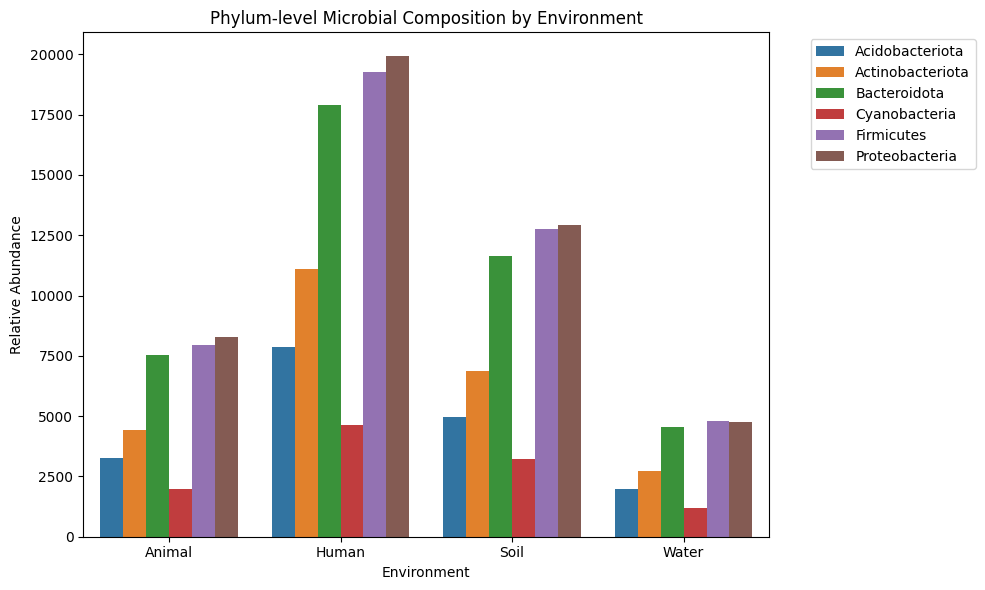

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.barplot(
    data=phylum_env,
    x="Environment",
    y="Count",
    hue="Phylum"
)
plt.ylabel("Relative Abundance")
plt.title("Phylum-level Microbial Composition by Environment")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

### BIOLOGICAL INTERPRETATION
Soil samples show higher Actinobacteriota and Acidobacteriota, consistent with oligotrophic conditions. Human-associated samples are enriched in Firmicutes and Bacteroidota, reflecting host-adapted gut communities.